# Import library

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [50]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
data_path = '/kaggle/input/diabetes-clusters2/'
df = pd.read_csv(data_path + "diabetes_with_cluster2.csv")

/kaggle/input/diabetes-clusters2/diabetes_with_cluster2.csv


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92897 entries, 0 to 92896
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           92897 non-null  object 
 1   age              92897 non-null  float64
 2   hypertension     92897 non-null  int64  
 3   heart_disease    92897 non-null  int64  
 4   bmi              92897 non-null  float64
 5   smoking_history  92897 non-null  object 
 6   diabetes         92897 non-null  int64  
 7   Cluster          92897 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 5.7+ MB


In [52]:
df.describe()

,age,hypertension,heart_disease,bmi,diabetes,Cluster
count,92897.000000,92897.000000,92897.000000,92897.000000,92897.000000,92897.000000
mean,41.968566,0.070293,0.039076,26.400457,0.075589,1.457614
std,22.629065,0.255641,0.193776,4.892423,0.264341,1.257262
min,0.080000,0.000000,0.000000,14.710000,0.000000,0.000000
25%,24.000000,0.000000,0.000000,23.480000,0.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,0.000000,1.000000
75%,60.000000,0.000000,0.000000,28.440000,0.000000,3.000000
max,80.000000,1.000000,1.000000,38.500000,1.000000,3.000000


In [53]:
df.isnull().sum()

gender             0
age                0
hypertension       0
heart_disease      0
bmi                0
smoking_history    0
diabetes           0
Cluster            0
dtype: int64

In [54]:
df.duplicated().sum()

27183

# Data Preparation

In [55]:
df.drop(df[df["gender"]=="Other"].index,inplace=True)
df.reset_index(drop=True,inplace=True)

In [56]:
df.drop_duplicates()

,gender,age,hypertension,heart_disease,bmi,smoking_history,diabetes,Cluster
0,Female,80.0,0,1,25.19,never_smoke,0,0
1,Female,54.0,0,0,27.32,no_info_smoke,0,0
2,Male,28.0,0,0,27.32,never_smoke,0,3
3,Female,36.0,0,0,23.45,current_smoke,0,3
4,Male,76.0,1,1,20.14,current_smoke,0,0
...,...,...,...,...,...,...,...,...
92891,Female,36.0,0,0,24.60,no_info_smoke,0,3
92893,Female,2.0,0,0,17.37,no_info_smoke,0,1
92894,Male,66.0,0,0,27.83,former_smoke,0,0
92895,Female,24.0,0,0,35.42,never_smoke,0,2


In [57]:
# Pisahkan fitur dan target
X = df.drop(columns=['Cluster', 'diabetes'])
y = df['Cluster']

# Split train (80%) dan sisa 20% dulu
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Split sisa 20% jadi val (10%) dan test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])

# Fitur kategorikal dan numerik
categorical_features = ['gender', 'smoking_history']
numeric_features = ['age', 'hypertension', 'heart_disease', 'bmi']

# Label encoding untuk 'gender'
le = LabelEncoder()
X_train['gender'] = le.fit_transform(X_train['gender'])
X_val['gender'] = le.transform(X_val['gender'])
X_test['gender'] = le.transform(X_test['gender'])

Train size: 74317
Validation size: 9290
Test size: 9290


In [58]:
# One-hot encoding untuk 'smoking_history'
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
smoking_history_encoded_train = ohe.fit_transform(X_train[['smoking_history']])
smoking_history_df_train = pd.DataFrame(smoking_history_encoded_train, columns=ohe.get_feature_names_out(['smoking_history']), index=X_train.index)
X_train = pd.concat([X_train.drop(columns=['smoking_history']), smoking_history_df_train], axis=1)

smoking_history_encoded_val = ohe.transform(X_val[['smoking_history']])
smoking_history_df_val = pd.DataFrame(smoking_history_encoded_val, columns=ohe.get_feature_names_out(['smoking_history']), index=X_val.index)
X_val = pd.concat([X_val.drop(columns=['smoking_history']), smoking_history_df_val], axis=1)

smoking_history_encoded_test = ohe.transform(X_test[['smoking_history']])
smoking_history_df_test = pd.DataFrame(smoking_history_encoded_test, columns=ohe.get_feature_names_out(['smoking_history']), index=X_test.index)
X_test = pd.concat([X_test.drop(columns=['smoking_history']), smoking_history_df_test], axis=1)

# Scaling hanya untuk fitur numerik
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val[numeric_features] = scaler.transform(X_val[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [59]:
import joblib
preprocessors = {
    'label_encoder': le,
    'onehot_encoder': ohe,
    'scaler': scaler
}
joblib.dump(preprocessors, 'preprocessors.joblib')

['preprocessors.joblib']

# Modelling

In [60]:
# Tentukan input shape dan jumlah kelas
input_dim = X_train.shape[1]
num_classes = len(y_train.unique())

# Callback custom untuk stop training saat val_accuracy >= 96%
class EarlyStoppingAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, accuracy=0.96):
        super().__init__()
        self.target_accuracy = accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None:
            if val_acc >= self.target_accuracy:
                print(f"\n🎉 Target val_accuracy >= {self.target_accuracy*100}% tercapai di epoch {epoch+1}, menghentikan training.")
                self.model.stop_training = True

# Build model sequential sederhana
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(input_dim,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 128)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,052 (39.27 KB)

 Trainable params: 10,052 (39.27 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Training model dengan callback
callbacks = [EarlyStoppingAtAccuracy(accuracy=0.96)]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

# Evaluasi di test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"🎯 Test Accuracy: {test_acc:.2%}")

Epoch 1/50
2323/2323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9438 - loss: 0.2012
🎉 Target val_accuracy >= 96.0% tercapai di epoch 1, menghentikan training.
2323/2323 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9438 - loss: 0.2012 - val_accuracy: 0.9834 - val_loss: 0.0420
🎯 Test Accuracy: 98.09%


# Evaluation

291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- Classification Report ---
              precision    recall  f1-score   support

   Cluster 0       0.99      0.98      0.99      3218
   Cluster 1       0.95      1.00      0.98      1576
   Cluster 2       0.98      0.98      0.98      1524
   Cluster 3       0.98      0.97      0.98      2972

    accuracy                           0.98      9290
   macro avg       0.98      0.98      0.98      9290
weighted avg       0.98      0.98      0.98      9290


--- Confusion Matrix ---
[[3145    9   21   43]
 [   0 1576    0    0]
 [  20    0 1501    3]
 [   1   70   10 2891]]


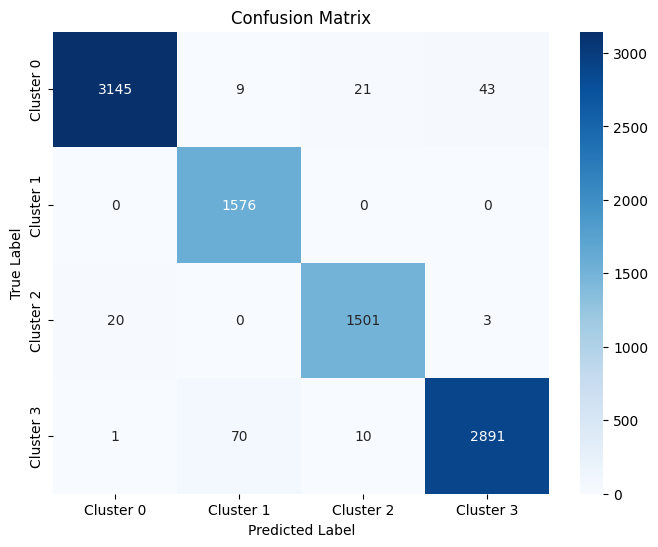

In [62]:
# Mendapatkan probabilitas prediksi dari model
y_pred_proba = model.predict(X_test)

y_pred = np.argmax(y_pred_proba, axis=1)

# --- Cetak Classification Report ---
print("\n--- Classification Report ---")
# Menentukan nama-nama kelas untuk laporan (opsional, tapi disarankan)
# Pastikan ini sesuai dengan nilai unik di kolom 'Cluster' Anda.
target_names = [f'Cluster {i}' for i in sorted(np.unique(y_test))] # Mengambil nama kelas dari y_test

print(classification_report(y_test, y_pred, target_names=target_names))

# --- Cetak Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualisasi Confusion Matrix (Opsional, tapi sangat direkomendasikan untuk interpretasi)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [63]:
# plt.figure(figsize=(8,5))
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

# Inference

In [64]:
# Konversi Model Klasifikasi Keras ke TensorFlow Lite ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model_cluster = converter.convert()

# Simpan model TFLite
with open('cluster_predictor.tflite', 'wb') as f:
    f.write(tflite_model_cluster)
print("\nModel klasifikasi cluster berhasil dikonversi dan disimpan sebagai 'cluster_predictor.tflite'")

Saved artifact at '/tmp/tmpc6tocj1u'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 11), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138902401994576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138902401998992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138902400965456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138902400966032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138902400964496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138902400966800: TensorSpec(shape=(), dtype=tf.resource, name=None)

Model klasifikasi cluster berhasil dikonversi dan disimpan sebagai 'cluster_predictor.tflite'


W0000 00:00:1749401584.454459      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1749401584.454484      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [65]:
class ClusterPredictor:
    def __init__(self, model_path='cluster_predictor.tflite'):
        """
        Inisialisasi ClusterPredictor dengan model TFLite
        
        Args:
            model_path (str): Path ke file model TFLite
        """
        # Load TFLite model
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.interpreter.allocate_tensors()
        
        # Get input and output tensors
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        
        # Inisialisasi preprocessors (akan di-fit dengan data training)
        self.label_encoder = None
        self.onehot_encoder = None
        self.scaler = None
        self.numeric_features = ['age', 'hypertension', 'heart_disease', 'bmi']
        
        print(f"Model TFLite berhasil dimuat dari {model_path}")
        print(f"Input shape: {self.input_details[0]['shape']}")
        print(f"Output shape: {self.output_details[0]['shape']}")
    
    def fit_preprocessors(self, X_train_original):
        """
        Fit preprocessors dengan data training original (sebelum preprocessing)
        
        Args:
            X_train_original (pd.DataFrame): Data training original untuk fitting preprocessors
        """
        # Fit Label Encoder untuk gender
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(X_train_original['gender'])
        
        # Fit One-Hot Encoder untuk smoking_history
        self.onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.onehot_encoder.fit(X_train_original[['smoking_history']])
        
        # Fit StandardScaler untuk fitur numerik
        self.scaler = StandardScaler()
        self.scaler.fit(X_train_original[self.numeric_features])
        
        print("Preprocessors berhasil di-fit dengan data training")
    
    def preprocess_data(self, data):
        """
        Preprocessing data sesuai dengan tahap training
        
        Args:
            data (pd.DataFrame): Data yang akan dipreprocessing
            
        Returns:
            np.ndarray: Data yang sudah dipreprocessing
        """
        # Copy data untuk menghindari modifikasi original
        X = data.copy()
        
        # Pastikan kolom yang diperlukan ada
        required_columns = ['gender', 'age', 'hypertension', 'heart_disease', 'bmi', 'smoking_history']
        missing_columns = [col for col in required_columns if col not in X.columns]
        if missing_columns:
            raise ValueError(f"Kolom yang hilang: {missing_columns}")
        
        # Label encoding untuk gender
        if self.label_encoder is None:
            raise ValueError("Label encoder belum di-fit. Jalankan fit_preprocessors() terlebih dahulu.")
        X['gender'] = self.label_encoder.transform(X['gender'])
        
        # One-hot encoding untuk smoking_history
        if self.onehot_encoder is None:
            raise ValueError("OneHot encoder belum di-fit. Jalankan fit_preprocessors() terlebih dahulu.")
        smoking_history_encoded = self.onehot_encoder.transform(X[['smoking_history']])
        smoking_history_df = pd.DataFrame(
            smoking_history_encoded, 
            columns=self.onehot_encoder.get_feature_names_out(['smoking_history']), 
            index=X.index
        )
        X = pd.concat([X.drop(columns=['smoking_history']), smoking_history_df], axis=1)
        
        # Scaling untuk fitur numerik
        if self.scaler is None:
            raise ValueError("Scaler belum di-fit. Jalankan fit_preprocessors() terlebih dahulu.")
        X[self.numeric_features] = self.scaler.transform(X[self.numeric_features])
        
        return X.values.astype(np.float32)
    
    def predict(self, data):
        """
        Prediksi cluster menggunakan model TFLite
        
        Args:
            data (pd.DataFrame): Data yang akan diprediksi
            
        Returns:
            tuple: (predicted_clusters, probabilities)
        """
        # Preprocessing data
        X_processed = self.preprocess_data(data)
        
        # Prediksi untuk setiap sample
        predictions = []
        probabilities = []
        
        for i in range(X_processed.shape[0]):
            # Set input tensor
            self.interpreter.set_tensor(self.input_details[0]['index'], X_processed[i:i+1])
            
            # Run inference
            self.interpreter.invoke()
            
            # Get output
            output_data = self.interpreter.get_tensor(self.output_details[0]['index'])
            probabilities.append(output_data[0])
            predictions.append(np.argmax(output_data[0]))
        
        return np.array(predictions), np.array(probabilities)
    
    def predict_single(self, gender, age, hypertension, heart_disease, bmi, smoking_history):
        """
        Prediksi cluster untuk satu sample
        
        Args:
            gender (str): Gender ('Male' atau 'Female')
            age (float): Umur
            hypertension (int): Hipertensi (0 atau 1)
            heart_disease (int): Penyakit jantung (0 atau 1)
            bmi (float): BMI
            smoking_history (str): Riwayat merokok ('never', 'former', 'current', 'not current', 'No Info')
            
        Returns:
            tuple: (predicted_cluster, probabilities)
        """
        # Buat DataFrame untuk satu sample
        data = pd.DataFrame({
            'gender': [gender],
            'age': [age],
            'hypertension': [hypertension],
            'heart_disease': [heart_disease],
            'bmi': [bmi],
            'smoking_history': [smoking_history]
        })
        
        predictions, probabilities = self.predict(data)
        return predictions[0], probabilities[0]

# Ambil data original sebelum preprocessing untuk fitting preprocessors
X_original = df.drop(columns=['Cluster', 'diabetes'])
y_original = df['Cluster']

# Split dengan cara yang sama untuk mendapatkan X_train_original
X_train_original, X_temp_original, y_train_original, y_temp_original = train_test_split(
    X_original, y_original, test_size=0.2, stratify=y_original, random_state=42)

# Inisialisasi predictor dan fit preprocessors dengan data training original
predictor = ClusterPredictor('cluster_predictor.tflite')
predictor.fit_preprocessors(X_train_original)

print("\n✅ ClusterPredictor berhasil diinisialisasi dan siap digunakan!")
print(f"Smoking history categories: {predictor.onehot_encoder.categories_[0]}")
print(f"Gender categories: {predictor.label_encoder.classes_}")

Model TFLite berhasil dimuat dari cluster_predictor.tflite
Input shape: [ 1 11]
Output shape: [1 4]
Preprocessors berhasil di-fit dengan data training

✅ ClusterPredictor berhasil diinisialisasi dan siap digunakan!
Smoking history categories: ['current_smoke' 'ever_smoke' 'former_smoke' 'never_smoke'
 'no_current_smoke' 'no_info_smoke']
Gender categories: ['Female' 'Male']


In [66]:
df[df['Cluster'] == 3].head()

,gender,age,hypertension,heart_disease,bmi,smoking_history,diabetes,Cluster
2,Male,28.0,0,0,27.32,never_smoke,0,3
3,Female,36.0,0,0,23.45,current_smoke,0,3
5,Female,20.0,0,0,27.32,never_smoke,0,3
9,Female,32.0,0,0,27.32,never_smoke,0,3
15,Male,15.0,0,0,30.36,never_smoke,0,3


In [67]:
# Contoh penggunaan untuk prediksi single sample
print("\n=== Contoh Prediksi Single Sample ===")

# Contoh data baru - pastikan menggunakan nilai yang valid
predicted_cluster, probabilities = predictor.predict_single(
    gender='Male',
    age=28.0,
    hypertension=0,
    heart_disease=0,
    bmi=27.32,
    smoking_history='never_smoke'  # Pastikan ini adalah salah satu dari: 'never', 'former', 'current', 'not current', 'No Info'
)
print(f"\nHasil Prediksi:")
print(f"  Predicted Cluster: {predicted_cluster}")
print(f"  Confidence: {probabilities.max():.3f}")
print(f"  All Probabilities: {probabilities}")


=== Contoh Prediksi Single Sample ===

Hasil Prediksi:
  Predicted Cluster: 3
  Confidence: 1.000
  All Probabilities: [5.7046418e-10 2.4116534e-10 2.8633740e-10 1.0000000e+00]


In [68]:
model.save('cluster_predictor2.h5')
print("Model Keras berhasil disimpan sebagai 'cluster_predictor2.h5'")
# !tensorflowjs_converter --input_format=keras cluster_predictor.h5 tfjs_model

Model Keras berhasil disimpan sebagai 'cluster_predictor2.h5'


In [69]:
# !pip install tensorflowjs
# !tensorflowjs_converter --input_format=keras kaggle/input/dataset-cluster-diabetes/cluster_predictor.h5 tfjs_model